In [ ]:
# suitable habitat for sable fish, as a case study
# first on 'current' habitat using historical data - glorys data
# later on 'projections' - dowsncaled data

In [204]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import glob
import os
import fnmatch

In [205]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# reginoal domain
#ldom = np.array([[42.9, 48.4],[-126, -123]]) 
ldom = np.array([[43, 48.5],[-129, -123]]) 
# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 


In [206]:
#get bathymetry from ETOPO1
fn = ldp+'/Etopo/ETOPO1_Ice_g_gmt4.grd'
ds_topo = xr.open_dataset(fn)
ds_topo.close()
topo = ds_topo.z  #(10801, 21601)
topo2=topo.sel(y=slice(ldom[0,0],ldom[0,1]),x=slice(ldom[1,0],ldom[1,1]))
x = topo2.x  #21601
y = topo2.y   #10801
X,Y=np.meshgrid(x,y)

In [207]:
qin = xr.open_dataset(ldp+'/QIN/qin_mask.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
qin = qin.where(qin!=0,np.nan)

eez = xr.open_dataset(ldp+'/QIN/eez_mask.nc')
eez.close()
eez.coords['lon'] = np.mod(eez.coords['lon'] + 180,360) - 180
eez = eez.region_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
eez = eez.where(eez!=0,np.nan)

Xm, Ym = np.meshgrid(eez.lon,eez.lat)

# number of pixels in the mask
npx = qin.count(dim=['lat','lon']).values

# Sablefish
### Depth: 175-1,450m
### Distance from shore: 0-241km
### Timing: Dec-March for spawning
## Temperature; 4.72-12.85C (2.28-20.56C) for adults
#### 3.10-8.3 for spawning (?)
## Oxygen (O2): 35.13-298.72 mmol/m3

In [208]:
# sablefish characteristics
t1, t2 = 4.72, 12.85
o1, o2 = 35.123, 298.72
o1 = o1 / 44.661  # conversion to ml/l
o2 = o2 / 44.661  
d1, d2 = 175, 1450
o2 = 10 # large limit to simulate no limit

In [209]:
def suit_hab_ind(fn, var, depth, th1, th2, fish):
    
    ds_Ts = xr.open_dataset(fn)
    ds_Ts.close()
    ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
    ds_Ts = ds_Ts[var].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
    if var=='thetao':
        ds_Ts = ds_Ts.where((ds_Ts>=th1)&(ds_Ts<=th2), np.nan)
    else:
        ds_Ts = ds_Ts.where((ds_Ts>=o1), np.nan)
        
    # 2 decadal averages for map plots - for sablefish FM, JAS
    ds_Ts_jf_pres = ds_Ts.sel(time=slice('2010-01-01','2019-12-31'))
    tmp1 = ds_Ts_jf_pres.where(ds_Ts_jf_pres.month<3, drop=True).mean(dim='time')
    tmp2 = ds_Ts_jf_pres.where((ds_Ts_jf_pres.month>6)&(ds_Ts_jf_pres.month<10), drop=True).mean(dim='time')
    pers=['Jan-Feb','Jul-Sep']
    fig=plt.figure(figsize=(5,3),dpi=150)
    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
        ax.set_extent([ldom[1,0],ldom[1,1],ldom[0,0],ldom[0,1]],crs=ccrs.PlateCarree())
        ax.set_xticks([-128,-126,-124], crs=ccrs.PlateCarree())
        ax.set_yticks([44, 46,48], crs=ccrs.PlateCarree())
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        plt.grid(True, zorder=0,alpha=0.5)
        ax.set_aspect(1.5)
        plt.contour(X,Y,topo2,[-3000,-2000,-1000,-500,-200,-150, -100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.5)
        plt.contour(X,Y,topo2,[ -d2, -d1],colors='b',linewidths=1, linestyles='solid', zorder=3, alpha=0.8)
        plt.plot(qbox[0,:],qbox[1,:],c='k',lw=2,zorder=5, alpha=0.7)
        
        if i==0:
            plt.contourf(ds_Ts.lon, ds_Ts.lat, tmp1, cmap='YlOrRd') # ,vmin=np.floor(t1), vmax=np.ceil(t2))
            cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(int(np.floor(ds_Ts_jf_pres.min())),int(np.ceil(ds_Ts_jf_pres.max()))+1,2)])
        else:
            plt.contourf(ds_Ts.lon, ds_Ts.lat, tmp2, cmap='YlOrRd') # ,vmin=np.floor(t1), vmax=np.ceil(t2))
            cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(int(np.floor(ds_Ts_jf_pres.min())),int(np.ceil(ds_Ts_jf_pres.max()))+1,2)])    
                
        cb.ax.tick_params(labelsize='x-small')
        cb.set_label(label='Temperature ($^{\circ}$C)', size='x-small', weight='bold')
        plt.text(-129.1,48.5, pers[i],fontsize=8,backgroundcolor='w')

    plt.tight_layout(h_pad=1)
    #fig.savefig('../figures/suitable_habitat/Glorys_climatology_'+var+'_'+depth+'.png')
    plt.show()
    ###
    ds_Ts_jf_pres = ds_Ts.sel(time=slice('2050-01-01','2059-12-31'))
    tmp1 = ds_Ts_jf_pres.where(ds_Ts_jf_pres.month<3, drop=True).mean(dim='time')
    tmp2 = ds_Ts_jf_pres.where((ds_Ts_jf_pres.month>6)&(ds_Ts_jf_pres.month<10), drop=True).mean(dim='time')
    pers=['Jan-Feb','Jul-Sep']
    fig=plt.figure(figsize=(5,3),dpi=150)
    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
        ax.set_extent([ldom[1,0],ldom[1,1],ldom[0,0],ldom[0,1]],crs=ccrs.PlateCarree())
        ax.set_xticks([-128,-126,-124], crs=ccrs.PlateCarree())
        ax.set_yticks([44, 46,48], crs=ccrs.PlateCarree())
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        plt.grid(True, zorder=0,alpha=0.5)
        ax.set_aspect(1.5)
        plt.contour(X,Y,topo2,[-3000,-2000,-1000,-500,-200,-150, -100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.5)
        plt.contour(X,Y,topo2,[ -d2, -d1],colors='b',linewidths=1, linestyles='solid', zorder=3, alpha=0.8)
        plt.plot(qbox[0,:],qbox[1,:],c='k',lw=2,zorder=5, alpha=0.7)
        
        if i==0:
            plt.contourf(ds_Ts.lon, ds_Ts.lat, tmp1, cmap='YlOrRd') # ,vmin=np.floor(t1), vmax=np.ceil(t2))
            cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(int(np.floor(tmp1.min())),int(np.ceil(tmp1.max()))+1,2)])    
        else:
            plt.contourf(ds_Ts.lon, ds_Ts.lat, tmp2, cmap='YlOrRd') # ,vmin=np.floor(t1), vmax=np.ceil(t2))
            cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(int(np.floor(tmp2.min())),int(np.ceil(tmp2.max()))+1,2)])    
                
        cb.ax.tick_params(labelsize='x-small')
        cb.set_label(label='Temperature ($^{\circ}$C)', size='x-small', weight='bold')
        plt.text(-129.1,48.5, pers[i],fontsize=8,backgroundcolor='w')

    plt.tight_layout(h_pad=1)
    #fig.savefig('../figures/suitable_habitat/Glorys_climatology_'+var+'_'+depth+'.png')
    plt.show()
    
    ###
    ds_Ts = ds_Ts*qin
    Sh_Ts = np.round(ds_Ts.count(dim=['lat','lon']).values*100/npx,1)
    yrs = ds_Ts.time.dt.year.values
    # smooth by decade
    yrsav = [*range(1990,2100,10)]
    Sh_Ts_dec = np.full((len(yrsav)-1),np.nan)
    for i in range(len(yrsav)-1):
        a=(yrs>=yrsav[i])&(yrs<=yrsav[i+1])
        Sh_Ts_dec[i] = np.nanmean(Sh_Ts[a])

    plt.figure(figsize=(8,4))
    plt.plot(ds_Ts.time, Sh_Ts, zorder=2)
    plt.grid(True, alpha=0.3, zorder=1)
    plt.ylabel('% of suitable habitat')
    plt.title('QIN '+fish+', '+var+' - '+depth)
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.plot(yrsav[1:],Sh_Ts_dec,'r.-', zorder=2)
    plt.grid(True, alpha=0.3, zorder=1)
    plt.ylabel('% of suitable habitat')
    plt.title('QIN '+fish+', '+var+' - '+depth)
    plt.show()

    Sh_Ts = Sh_Ts.reshape((int(len(Sh_Ts)/12)), 12)
    plt.figure(figsize=(5,8))
    ax=sns.heatmap(Sh_Ts, xticklabels=months, yticklabels=np.unique(ds_Ts.time.dt.year.values), linewidth=0, alpha=0.8)
    ax.invert_yaxis()
    plt.title('QIN '+fish+', '+var+' - '+depth)
    plt.show()
    
    # # smooth by decade
    yrs = np.unique(ds_Ts.time.dt.year.values)
    Sh_Ts_dec_hv = np.full((len(yrsav)-1,12),np.nan)
    for i in range(len(yrsav)-1):
        a=(yrs>=yrsav[i])&(yrs<=yrsav[i+1])
        for j in range(12):
            tmp = Sh_Ts[:,j]
            Sh_Ts_dec_hv[i,j] = np.nanmean(tmp[a])
    
    plt.figure(figsize=(5,8))
    ax=sns.heatmap(Sh_Ts_dec_hv, xticklabels=months, yticklabels=yrsav[1:], linewidth=0, alpha=0.9)
    ax.invert_yaxis()
    plt.title('QIN '+fish+', '+var+' - '+depth)
    plt.show()
    

## Example of how each file is analyzed

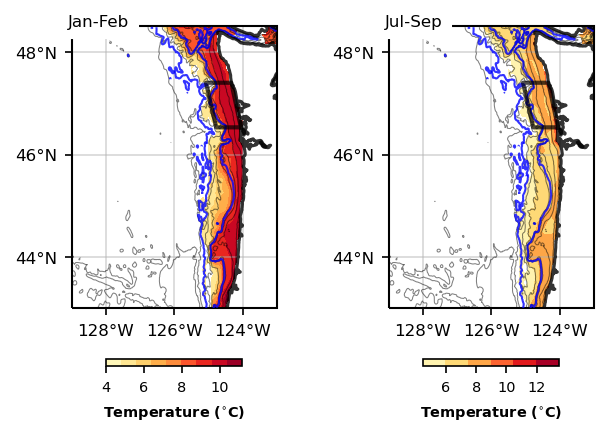

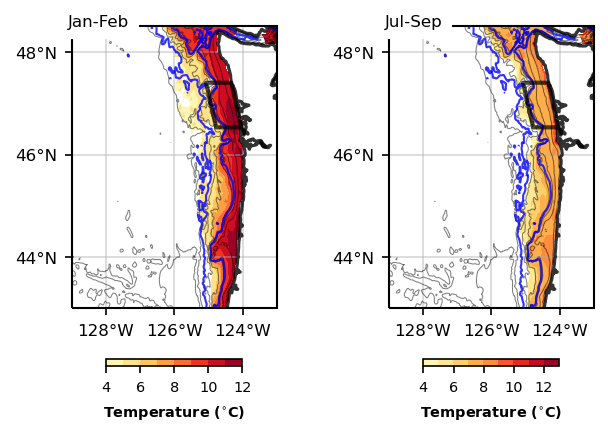

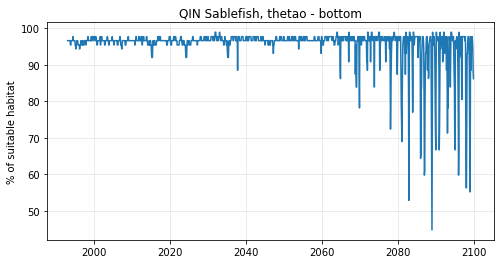

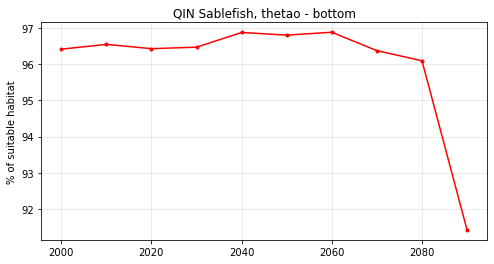

ValueError: cannot reshape array of size 1283 into shape (106,12)

In [213]:
##### fn = ldp+'QIN/downscaled_data/bottomT/GFDL-ESM4_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_0.nc'
fn = ldp+'QIN/downscaled_data/ssp585/thetao/bottom/GFDL-ESM4_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_subset.nc'
suit_hab_ind(fn, 'thetao', 'bottom', t1, t2, 'Sablefish')

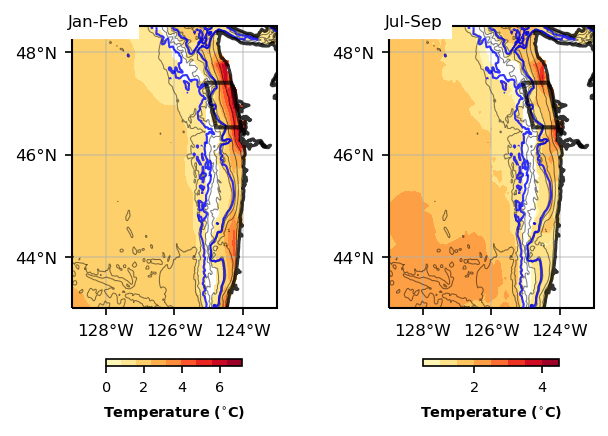

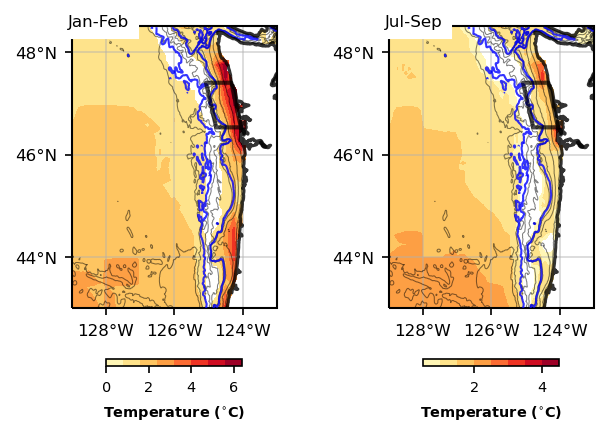

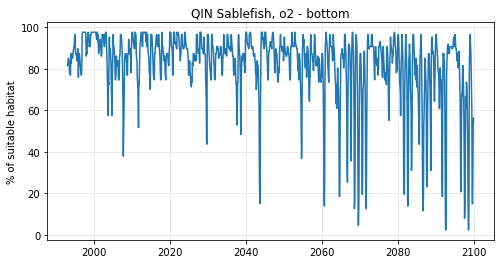

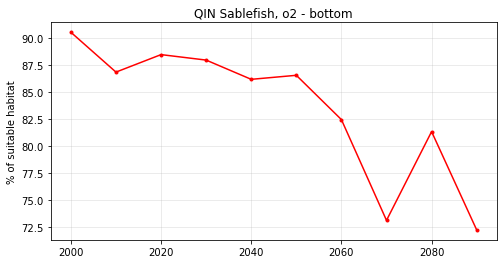

ValueError: cannot reshape array of size 1283 into shape (106,12)

In [214]:
fn = ldp+'QIN/downscaled_data/ssp585/O2/bottom/CanESM5-CanOE_r3i1p2f1_sd+ba_final_o2_bottom_depth_None_subset.nc'
suit_hab_ind(fn, 'o2', 'bottom', t1, t2, 'Sablefish')

In [199]:
def suit_hab_ens(dr, var, depth, th1, th2, qin, fish, fut_dec):
    
    fns = glob.glob(dr+'/*.nc')
    yrsav = [*range(1990,2100,10)]
    Sh_Ts_dec = np.full((len(yrsav)-1,len(fns)),np.nan) # decades and num of models
    Sh_Ts_dec_hv_all = np.full((len(yrsav)-1,12,len(fns)),np.nan)
    Sh_Ts_dec_hv = np.full((len(yrsav)-1,12),np.nan)
    Sh_Ts_dec_hvs = np.full((len(yrsav)-1,12),np.nan)
    
    # data set for average maps
    for modn,fn in enumerate(fns):
        #print(fn)
        ds_Ts = xr.open_dataset(fn)
        ds_Ts.close()
        ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
        ds_Ts = ds_Ts[var].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
        ds_Ts = ds_Ts.where((ds_Ts>=th1)&(ds_Ts<=th2), np.nan)

        ####
        # 2 decadal averages for map plots - for sablefish FM, JAS
        ds_Ts_pres = ds_Ts.sel(time=slice('2010-01-01','2019-12-31'))
        tmp1 = ds_Ts_pres.where(ds_Ts_pres.month<3, drop=True).mean(dim='time')
        tmp2 = ds_Ts_pres.where((ds_Ts_pres.month>6)&(ds_Ts_pres.month<10), drop=True).mean(dim='time')
        
        if modn==0:
            # create np array
            sh_seas_fmap1_pres = np.full((len(ds_Ts.lat.values),len(ds_Ts.lon.values),len(fns)),np.nan)
            sh_seas_fmap2_pres = np.full((len(ds_Ts.lat.values),len(ds_Ts.lon.values),len(fns)),np.nan)
            
        sh_seas_fmap1_pres[:,:,modn] = tmp1
        sh_seas_fmap2_pres[:,:,modn] = tmp2
        
        # 2 decadal averages for map plots - for sablefish FM, JAS
        ds_Ts_fut = ds_Ts.sel(time=slice(str(fut_dec)+'-01-01',str(fut_dec+9)+'-12-31'))
        tmp1 = ds_Ts_fut.where(ds_Ts_fut.month<3, drop=True).mean(dim='time')
        tmp2 = ds_Ts_fut.where((ds_Ts_fut.month>6)&(ds_Ts_fut.month<10), drop=True).mean(dim='time')
        
        if modn==0:
            # create np array
            sh_seas_fmap1_fut = np.full((len(ds_Ts.lat.values),len(ds_Ts.lon.values),len(fns)),np.nan)
            sh_seas_fmap2_fut = np.full((len(ds_Ts.lat.values),len(ds_Ts.lon.values),len(fns)),np.nan)
            
        sh_seas_fmap1_fut[:,:,modn] = tmp1
        sh_seas_fmap2_fut[:,:,modn] = tmp2
        
        ####
        
        ds_Ts = ds_Ts*qin
        Sh_Ts = np.round(ds_Ts.count(dim=['lat','lon']).values*100/npx,1)
        yrs = ds_Ts.time.dt.year.values
        # smooth by decade
        for i in range(len(yrsav)-1):
            a=(yrs>=yrsav[i])&(yrs<=yrsav[i+1])
            Sh_Ts_dec[i,modn] = np.nanmean(Sh_Ts[a])

        Sh_Ts = Sh_Ts.reshape((int(len(Sh_Ts)/12)), 12)

        # # smooth by decade
        yrs = np.unique(ds_Ts.time.dt.year.values)
        for i in range(len(yrsav)-1):
            a=(yrs>=yrsav[i])&(yrs<=yrsav[i+1])
            for j in range(12):
                tmp = Sh_Ts[:,j]
                Sh_Ts_dec_hv_all[i,j,modn] = np.nanmean(tmp[a])
    
    # decadal values
    Sh_Ts_decmean = Sh_Ts_dec.mean(axis=1)
    Sh_Ts_decstd = Sh_Ts_dec.std(axis=1)
    plt.figure(figsize=(8,4))
    plt.plot(yrsav[1:],Sh_Ts_dec,'.-', zorder=2, c='grey', alpha=0.5)
    plt.plot(yrsav[1:],Sh_Ts_decmean,'d-', zorder=3, c='tab:red', alpha=0.9)
    plt.errorbar(yrsav[1:],Sh_Ts_decmean,yerr=Sh_Ts_decstd,c='tab:red', alpha=0.9, zorder=3)
    plt.grid(True, alpha=0.3, zorder=1)
    plt.ylabel('% of suitable habitat')
    plt.title(fish+', '+depth+' '+var)
    plt.savefig('../figures/suitable_habitat/'+fish+'+_ensemblesuitablehabitatdecadal_'+var+'_'+depth+'_timeseries.png')
    plt.show()

    for i in range(len(yrsav)-1):
        for j in range(12):
            Sh_Ts_dec_hv[i,j] = np.nanmedian(Sh_Ts_dec_hv_all[i,j,:])
            Sh_Ts_dec_hvs[i,j] = np.nanstd(Sh_Ts_dec_hv_all[i,j,:])
    
    plt.figure(figsize=(5.5,8))
    if var=='thetao':
        ax=sns.heatmap(Sh_Ts_dec_hv, xticklabels=months, yticklabels=yrsav[1:], linewidths=0, alpha=0.85)
    else:
        ax=sns.heatmap(Sh_Ts_dec_hv, xticklabels=months, yticklabels=yrsav[1:], linewidths=0, alpha=0.85,cmap="YlGnBu_r")
    X2, Y2 = np.meshgrid(np.arange(0.5,12),np.arange(0.5,len(yrsav[1:])))
    plt.scatter(X2, Y2, s=Sh_Ts_dec_hvs,c='w',marker='o', edgecolor='grey', alpha=0.6)
    plt.xticks(rotation=80)
    plt.yticks(rotation=0)
    ax.invert_yaxis()
    plt.title(fish+', '+depth+' '+var)
    plt.savefig('../figures/suitable_habitat/'+fish+'+_ensemblesuitablehabitatdecadal_'+var+'_'+depth+'_hovmuller.png')
    plt.show()
    
    ###
    sh_seas_map1_av=np.nanmean(sh_seas_fmap1_pres,axis=2)
    sh_seas_map2_av=np.nanmean(sh_seas_fmap2_pres,axis=2)
    print('Present 2010-2019')
    tmp1 = xr.Dataset(data_vars=dict(seas1=(['lat','lon'],sh_seas_map1_av)), coords={'lon':ds_Ts.lon.values,'lat':ds_Ts.lat.values})
    tmp2 = xr.Dataset(data_vars=dict(seas2=(['lat','lon'],sh_seas_map2_av)), coords={'lon':ds_Ts.lon.values,'lat':ds_Ts.lat.values})
    pers=['Jan-Feb','Jul-Sep']
    fig=plt.figure(figsize=(5,3),dpi=150)
    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
        ax.set_extent([ldom[1,0],ldom[1,1],ldom[0,0],ldom[0,1]],crs=ccrs.PlateCarree())
        ax.set_xticks([-128,-126,-124], crs=ccrs.PlateCarree())
        ax.set_yticks([44, 46,48], crs=ccrs.PlateCarree())
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        plt.grid(True, zorder=0,alpha=0.5)
        ax.set_aspect(1.5)
        plt.contour(X,Y,topo2,[-3000,-2000,-1000,-500,-200,-150, -100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.5)
        plt.contour(X,Y,topo2,[ -d2, -d1],colors='b',linewidths=1, linestyles='solid', zorder=3, alpha=0.8)
        plt.plot(qbox[0,:],qbox[1,:],c='k',lw=2,zorder=5, alpha=0.7)
        
        if i==0:
            plt.contourf(ds_Ts.lon, ds_Ts.lat, tmp1.seas1, cmap='YlOrRd')
            cb = plt.colorbar(fraction=0.02, orientation='horizontal',ticks=[*range(int(np.floor(tmp1.seas1.min())),int(np.ceil(tmp1.seas1.max())))])      
        else:
            plt.contourf(ds_Ts.lon, ds_Ts.lat, tmp2.seas2, cmap='YlOrRd')
            cb = plt.colorbar(fraction=0.02, orientation='horizontal',ticks=[*range(int(np.floor(tmp1.seas1.min())),int(np.ceil(tmp1.seas1.max())))])    
                
        cb.ax.tick_params(labelsize='x-small')
        cb.set_label(label='Temperature ($^{\circ}$C)', size='x-small', weight='bold')
        plt.text(-129.1,48.5, pers[i],fontsize=8,backgroundcolor='w')

    plt.tight_layout(h_pad=1)
    #fig.savefig('../figures/suitable_habitat/Glorys_climatology_'+var+'_'+depth+'.png')
    plt.show()
    
    sh_seas_map1_av=np.nanmean(sh_seas_fmap1_fut,axis=2)
    sh_seas_map2_av=np.nanmean(sh_seas_fmap2_fut,axis=2)
    print('Future '+str(fut_dec)+'-'+str(fut_dec+9))
    #print(sh_seas_jf_map1_av.shape)
    tmp1 = xr.Dataset(data_vars=dict(seas1=(['lat','lon'],sh_seas_map1_av)), coords={'lon':ds_Ts.lon.values,'lat':ds_Ts.lat.values})
    tmp2 = xr.Dataset(data_vars=dict(seas2=(['lat','lon'],sh_seas_map2_av)), coords={'lon':ds_Ts.lon.values,'lat':ds_Ts.lat.values})
    pers=['Jan-Feb','Jul-Sep']
    fig=plt.figure(figsize=(5,3),dpi=150)
    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
        ax.set_extent([ldom[1,0],ldom[1,1],ldom[0,0],ldom[0,1]],crs=ccrs.PlateCarree())
        ax.set_xticks([-128,-126,-124], crs=ccrs.PlateCarree())
        ax.set_yticks([44, 46,48], crs=ccrs.PlateCarree())
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        plt.grid(True, zorder=0,alpha=0.5)
        ax.set_aspect(1.5)
        plt.contour(X,Y,topo2,[-3000,-2000,-1000,-500,-200,-150, -100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.5)
        plt.contour(X,Y,topo2,[ -d2, -d1],colors='b',linewidths=1, linestyles='solid', zorder=3, alpha=0.8)
        plt.plot(qbox[0,:],qbox[1,:],c='k',lw=2,zorder=5, alpha=0.7)
        
        if i==0:
            plt.contourf(ds_Ts.lon, ds_Ts.lat, tmp1.seas1, cmap='YlOrRd')
            cb = plt.colorbar(fraction=0.02, orientation='horizontal',ticks=[*range(int(np.floor(tmp1.seas1.min())),int(np.ceil(tmp1.seas1.max())))])    
        else:
            plt.contourf(ds_Ts.lon, ds_Ts.lat, tmp2.seas2, cmap='YlOrRd')
            cb = plt.colorbar(fraction=0.02, orientation='horizontal',ticks=[*range(int(np.floor(tmp2.seas2.min())),int(np.ceil(tmp2.seas2.max())))])  
                
        cb.ax.tick_params(labelsize='x-small')
        cb.set_label(label='Temperature ($^{\circ}$C)', size='x-small', weight='bold')
        plt.text(-129.1,48.5, pers[i],fontsize=8,backgroundcolor='w')

    plt.tight_layout(h_pad=1)
    #fig.savefig('../figures/suitable_habitat/Glorys_climatology_'+var+'_'+depth+'.png')
    plt.show()
    

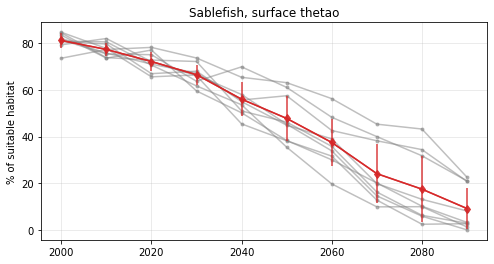

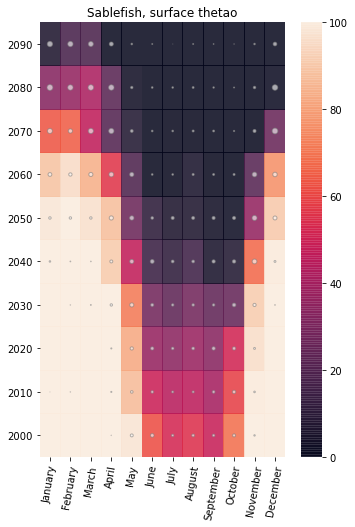

Present 2010-2019


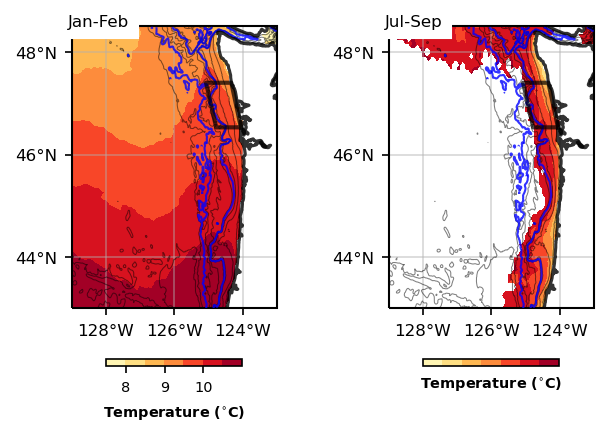

Future 2050-2059


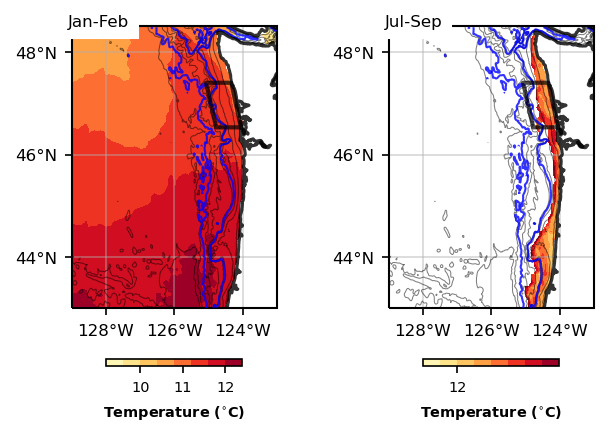

In [200]:
fn = ldp+'QIN/downscaled_data/surfaceT/'
suit_hab_ens(fn, 'thetao', 'surface', t1, t2, qin, 'Sablefish', 2050)


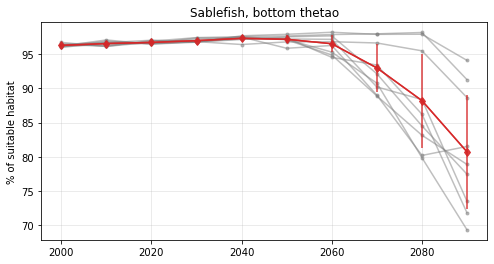

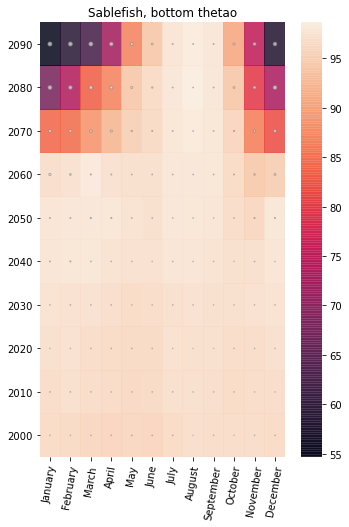

Present 2010-2019


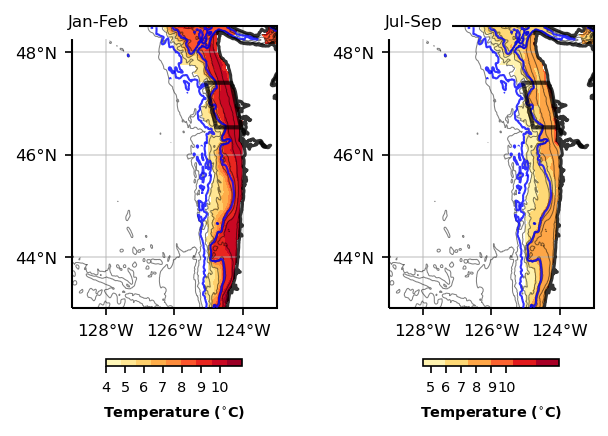

Future 2070-2079


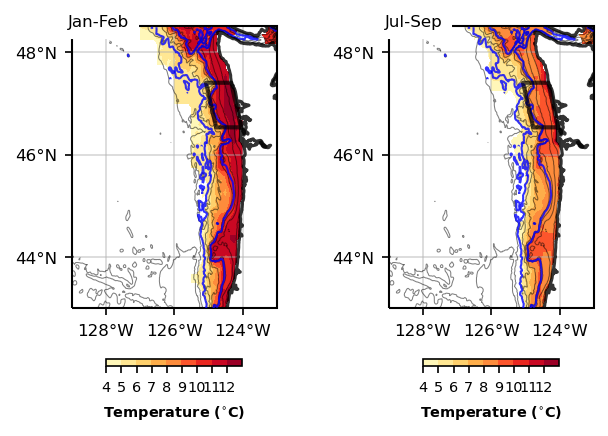

In [201]:
fn = ldp+'QIN/downscaled_data/bottomT/'
suit_hab_ens(fn, 'thetao', 'bottom', t1, t2, qin, 'Sablefish',2070)


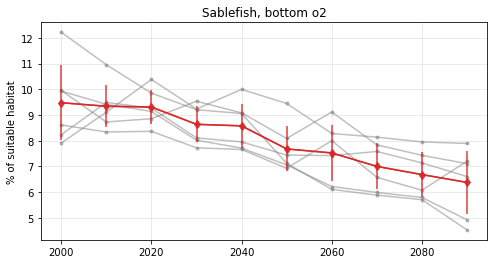

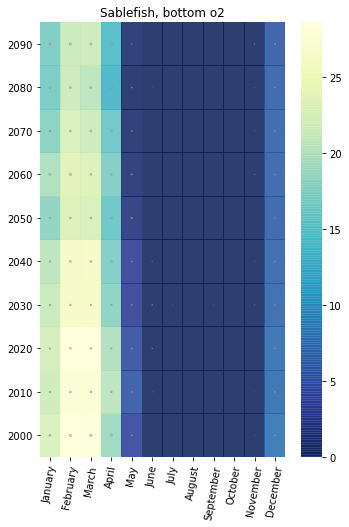

Present 2010-2019


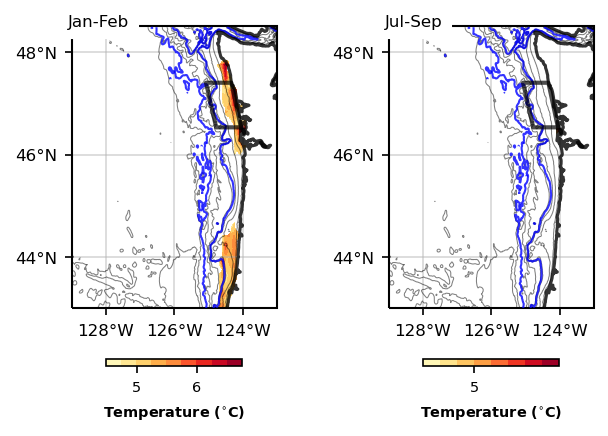

Future 2070-2079


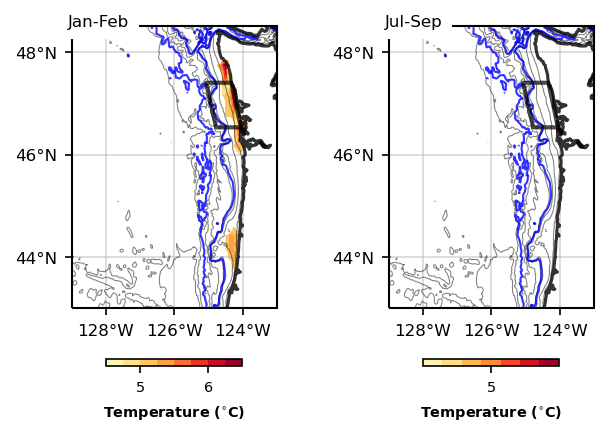

In [203]:
fn = ldp+'QIN/downscaled_data/bottomO2/'
suit_hab_ens(fn, 'o2', 'bottom', t1, t2, qin, 'Sablefish',2070)


In [186]:
# combined T and O2
def suit_hab_ens_2var(dr, depth, th1, th2, o1, o2, qin, fish):
    
    yrsav = [*range(1990,2100,10)]
    Sh_dec = np.full((len(yrsav)-1,len(fns)),np.nan) # decades and num of models
    Sh_dec_hv_all = np.full((len(yrsav)-1,12,len(fns)),np.nan)
    Sh_dec_hv = np.full((len(yrsav)-1,12),np.nan)
    Sh_dec_hvs = np.full((len(yrsav)-1,12),np.nan)
    
    # Temperature
    dr = dr+depth+'T/'
    fns = glob.glob(dr+'/*.nc')
    
    
    for modn,fn in enumerate(fns):
        #print(fn)
        ds_Ts = xr.open_dataset(fn)
        ds_Ts.close()
        ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
        ds_Ts = ds_Ts[var].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
        ds_Ts = ds_Ts*qin
        ds_Ts = ds_Ts.where((ds_Ts>=th1)&(ds_Ts<=th2), np.nan)

        Sh_Ts = np.round(ds_Ts.count(dim=['lat','lon']).values*100/npx,1)
        yrs = ds_Ts.time.dt.year.values
        # smooth by decade
        for i in range(len(yrsav)-1):
            a=(yrs>=yrsav[i])&(yrs<=yrsav[i+1])
            Sh_Ts_dec[i,modn] = np.nanmean(Sh_Ts[a])

        Sh_Ts = Sh_Ts.reshape((int(len(Sh_Ts)/12)), 12)

        # # smooth by decade
        yrs = np.unique(ds_Ts.time.dt.year.values)
        for i in range(len(yrsav)-1):
            a=(yrs>=yrsav[i])&(yrs<=yrsav[i+1])
            for j in range(12):
                tmp = Sh_Ts[:,j]
                Sh_Ts_dec_hv_all[i,j,modn] = np.nanmean(tmp[a])
    
    # decadal values
    Sh_Ts_decmean = Sh_Ts_dec.mean(axis=1)
    Sh_Ts_decstd = Sh_Ts_dec.std(axis=1)
    plt.figure(figsize=(8,4))
    plt.plot(yrsav[1:],Sh_Ts_dec,'.-', zorder=2, c='grey', alpha=0.5)
    plt.plot(yrsav[1:],Sh_Ts_decmean,'d-', zorder=3, c='tab:red', alpha=0.9)
    plt.errorbar(yrsav[1:],Sh_Ts_decmean,yerr=Sh_Ts_decstd,c='tab:red', alpha=0.9, zorder=3)
    plt.grid(True, alpha=0.3, zorder=1)
    plt.ylabel('% of suitable habitat')
    plt.title(fish+', '+depth+' '+var)
    plt.savefig('../figures/suitable_habitat/'+fish+'+_ensemblesuitablehabitatdecadal_'+var+'_'+depth+'_timeseries.png')
    plt.show()

    for i in range(len(yrsav)-1):
        for j in range(12):
            Sh_Ts_dec_hv[i,j]=np.nanmedian(Sh_Ts_dec_hv_all[i,j,:])
            Sh_Ts_dec_hvs[i,j] = np.nanstd(Sh_Ts_dec_hv_all[i,j,:])
    
    plt.figure(figsize=(5.5,8))
    if var=='thetao':
        ax=sns.heatmap(Sh_Ts_dec_hv, xticklabels=months, yticklabels=yrsav[1:], linewidths=0, alpha=0.85)
    else:
        ax=sns.heatmap(Sh_Ts_dec_hv, xticklabels=months, yticklabels=yrsav[1:], linewidths=0, alpha=0.85,cmap="YlGnBu_r")
    X, Y = np.meshgrid(np.arange(0.5,12),np.arange(0.5,len(yrsav[1:])))
    plt.scatter(X, Y, s=Sh_Ts_dec_hvs,c='w',marker='o', edgecolor='grey', alpha=0.6)
    plt.xticks(rotation=80)
    plt.yticks(rotation=0)
    ax.invert_yaxis()
    plt.title(fish+', '+depth+' '+var)
    plt.savefig('../figures/suitable_habitat/'+fish+'+_ensemblesuitablehabitatdecadal_'+var+'_'+depth+'_hovmuller.png')
    plt.show()
    

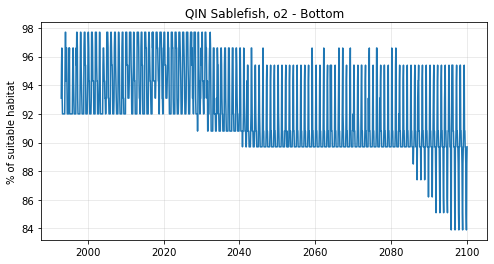

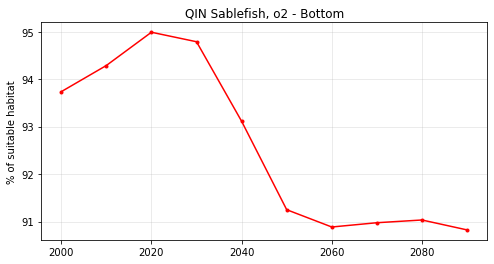

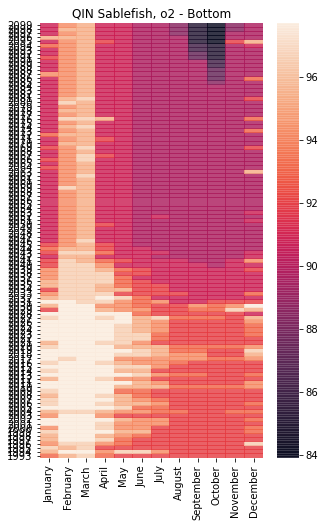

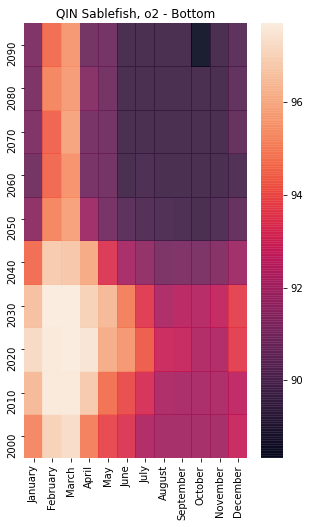

In [18]:
#fn = ldp+'QIN/downscaled_data/bottomO2/IPSL-CM6A-LR_r1i1p1f1_sd+ba_final_o2_bottom_depth_None_0.nc'
fn = ldp+'QIN/downscaled_data/bottomO2/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_o2_bottom_depth_None_0.nc'
suit_hab_ind(fn, 'o2', 'Bottom', o1, o2, 'Sablefish')

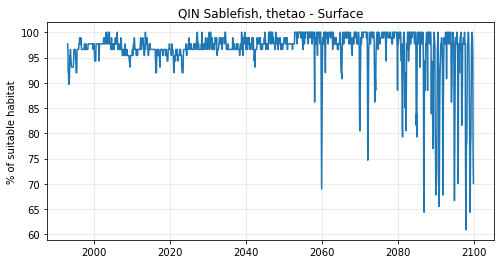

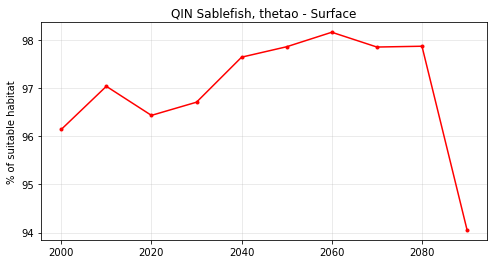

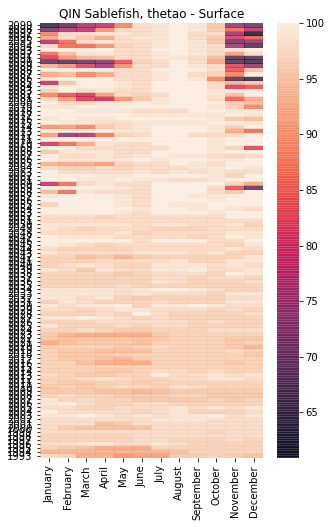

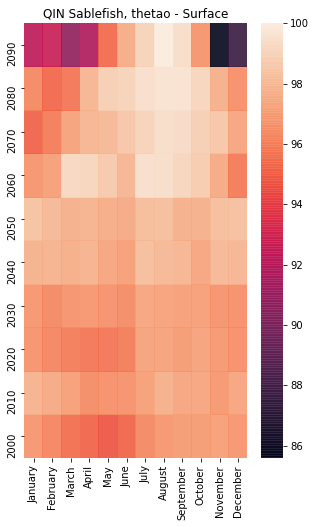

In [12]:
#fn = ldp+'QIN/downscaled_data/surfaceO2/IPSL-CM6A-LR_r1i1p1f1_sd+ba_final_o2_surface_depth_5_0.nc'
fn = ldp+'QIN/downscaled_data/bottomT/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_0.nc'
suit_hab_ind(fn, 'thetao', 'Surface', t1, t2, 'Sablefish')



/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomT/IPSL-CM6A-LR_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomT/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomT/UKESM1-0-LL_r8i1p1f2_sd+ba_final_thetao_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomT/CanESM5_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomT/UKESM1-0-LL_r3i1p1f2_sd+ba_final_thetao_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomT/UKESM1-0-LL_r2i1p1f2_sd+ba_final_thetao_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomT/UKESM1-0-LL_r1i1p1f2_sd+ba_final_thetao_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomT/GFDL-ESM4_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_0.nc
/Users/sol/Documents/LargeD

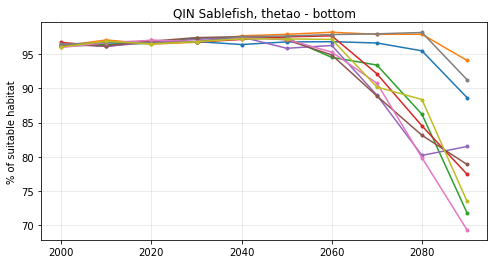

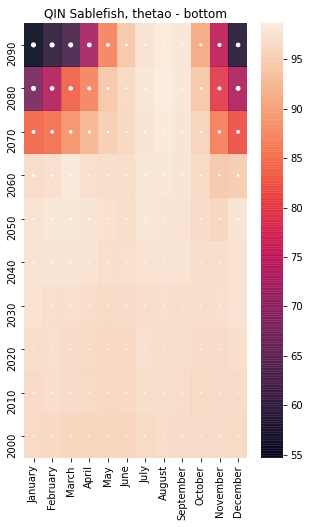

In [13]:
fn = ldp+'QIN/downscaled_data/bottomT/'
suit_hab_ens(fn, 'thetao', 'bottom', t1, t2, qin, 'Sablefish')


/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomO2/UKESM1-0-LL_r1i1p1f2_sd+ba_final_o2_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomO2/UKESM1-0-LL_r2i1p1f2_sd+ba_final_o2_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomO2/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_o2_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomO2/IPSL-CM6A-LR_r1i1p1f1_sd+ba_final_o2_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomO2/CanESM5_r1i1p1f1_sd+ba_final_o2_bottom_depth_None_0.nc
/Users/sol/Documents/LargeData/QIN/downscaled_data/bottomO2/UKESM1-0-LL_r3i1p1f2_sd+ba_final_o2_bottom_depth_None_0.nc


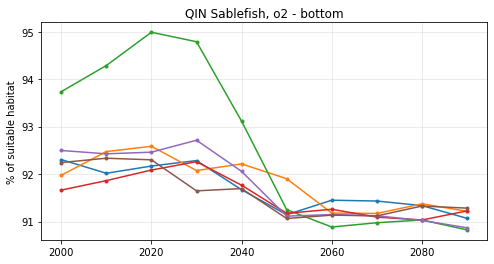

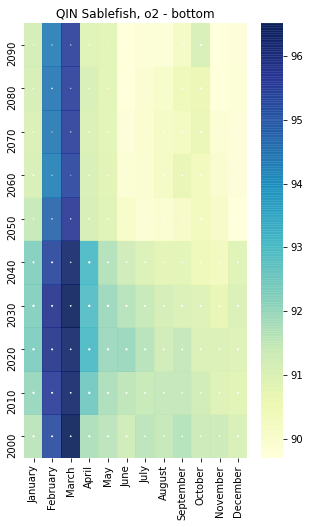

In [19]:
fn = ldp+'QIN/downscaled_data/bottomO2/'
suit_hab_ens(fn, 'o2', 'bottom', o1, o2, qin, 'Sablefish')
